<h1>0. Packages</h1>

In [1]:
import numpy as np
import re
import skyfield.sgp4lib as spg4
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.stats import norm
import scipy.stats as stats
from enum import Enum    
%matplotlib inline

debris_category = Enum('Category', 'rb sc soc')

<h1>1. Data Structure</h1>

<h3>1.1 Satellite Structure</h3>

Creating an object to represent satellite from 3le.txt <br>
May end up using implementation from another package

<b>Data sources:<b><br>
https://www.space-track.org    
https://www.celestrak.com/NORAD/documentation/spacetrk.pdf

<b>Information about 3le/2le:</b><br>
https://en.wikipedia.org/wiki/Two-line_element_set#cite_note-nasahelp-12
https://spaceflight.nasa.gov/realdata/sightings/SSapplications/Post/JavaSSOP/SSOP_Help/tle_def.html

In [2]:
class two_line_element:
    
    def __init__(self, data):
        self.parse_data(data)
        
    def parse_data(self, satelite_data):
        self.title = satelite_data[0]
        line_one = satelite_data[1].split()
        line_two = satelite_data[2].split()

        self.catalog_number = re.search('[0-9]{1,5}', line_one[0]).group()
        self.classification = re.search('[UCS]', line_one[0]).group()

        international_designator = re.search('([0-9]{2})([0-9]{3})(\w{1,3})', line_one[1])
        self.launch_year = international_designator.group(1)
        self.launch_number = international_designator.group(2)
        self.launch_piece =  international_designator.group(3)

        epoch = re.search('([0-9]{2})(\d+\.\d+)', line_one[2])
        self.epoch_year = epoch.group(1)
        self.epoch_day = epoch.group(2)

        self.ballistic_coefficient = float(line_one[3])
        self.mean_motion_double_prime = line_one[4]
        self.BSTAR = line_one[5]

        self.inclination = line_two[1]
        self.right_ascension_of_ascending_node = line_two[2]
        self.eccentricity = line_two[3]
        self.argument_of_perigee = line_two[4]

        mean_anomaly = line_two[5]

<h3>Data structure implementation using spg4 from skyfield library<h3>

In [3]:
# Opening the .txt file
with open("3le.txt") as f:
    txt = f.read()
    
sat_lines = re.findall('(.*?)\n(.*?)\n(.*?)\n', txt)

# Preview of `sat_lines`, each element should be the three lines representing a satellite
print(sat_lines[0])

# Convert each group of 3 lines into a satelite object
def line_element_to_satellite(lines):
    title = lines[0]
    line1 = lines[1]
    line2 = lines[2]
    return spg4.EarthSatellite(line1, line2, name=title)

satellites = [line_element_to_satellite(lines) for lines in sat_lines]

# Verify data structure by finding element representing the ISS
iss_index = [sat.name for sat in satellites].index("0 ISS (ZARYA)")
iss = satellites[iss_index]

('0 VANGUARD 1', '1     5U 58002B   19352.86539842  .00000184  00000-0  20948-3 0  9994', '2     5  34.2610  67.7117 1845282 255.2293  83.7559 10.84789954185624')


<h3>1.2 Celestial Bodies</h3>


de421.bsp is a Ephemerides provided by JPL Horizon which has the calculated positions of celestial bodies within a certain time interval. de421 is commonly used due to its small size and its relativley up to date information

In [4]:
from skyfield.api import load, EarthSatellite
ts = load.timescale(builtin=True)

# Loading the data from de421.bsp using skyfield 
planets = load('de421.bsp')

# Finding the data about Earth
earth = planets["Earth"]

<h3>1.3 Celestial Bodies</h3>

Plotting the satellite data in a 3D view.<br>
Accidently broke my implementation so need to start with the below base and get it to plot the ISS again.

<b>Source:</b> https://space.stackexchange.com/questions/25958/how-can-i-plot-a-satellites-orbit-in-3d-from-a-tle-using-python-and-skyfield

period 6307.12290204 seconds or 105.118715034 minutes
inclination 57.0 degrees
initial position [7378.137    0.       0.   ] km
initial velocity [   0.         4003.17019194 6164.34152276] m/s
initial speed 7350.13455625 m/s
('hw was None so set to:', 8115.951438943057)
('centers are: ', [-0.00011361183214830817, 0.0, 0.0])
('hw is:       ', 8115.951438943057)


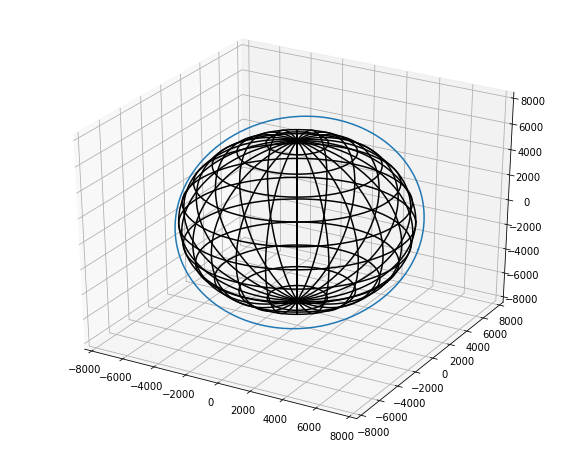

In [5]:
def makecubelimits(axis, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims] 
    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
        print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
            print("ok hw requested: ", hwx, hwy, hwz)
            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
            print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)

    return centers, hw

def deriv(X, t):
    x, v = X.reshape(2, -1)
    acc = -GMe * x * ((x**2).sum())**-1.5
    return np.hstack((v, acc))

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint as ODEint
from mpl_toolkits.mplot3d import Axes3D

halfpi, pi, twopi = [f*np.pi for f in (0.5, 1, 2)]
degs, rads = 180/pi, pi/180

km  = 0.001
GMe = 3.986E+14 # m^3/s^2
Re  = 6378137.  # meters
alt = 1e6     # meters
a   = Re + alt
T   = twopi * np.sqrt(a**3/GMe)

v0  = np.sqrt(GMe/a)
incdegs = 57.

inc = rads * incdegs
cinc, sinc = [f(inc) for f in (np.cos, np.sin)]

X0 = np.array([Re+alt, 0, 0] + [0, cinc*v0, sinc*v0])

print("period {} seconds or {} minutes".format(T, T/60))
print("inclination {} degrees".format(incdegs))
print("initial position {} km".format(km * X0[:3]))
print("initial velocity {} m/s".format(X0[3:]))
print("initial speed {} m/s".format(v0))

times = np.linspace(0, T, 201)

answer, info = ODEint(deriv, X0, times, full_output=True)


theta = np.linspace(0, twopi, 201)
cth, sth, zth = [f(theta) for f in (np.cos, np.sin, np.zeros_like)]
lon0 = Re*np.vstack((cth, zth, sth))
lons = []
for phi in rads*np.arange(0, 180, 15):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                     lon0[1]*cph + lon0[0]*sph,
                     lon0[2]) )
    lons.append(lon)

lat0 = Re*np.vstack((cth, sth, zth))
lats = []
for phi in rads*np.arange(-75, 90, 15):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lat = Re*np.vstack((cth*cph, sth*cph, zth+sph))
    lats.append(lat)

if True:
    fig = plt.figure(figsize=[10, 8])  # [12, 10]

    ax  = fig.add_subplot(1, 1, 1, projection='3d')

    x, y, z = answer.T[:3]
    ax.plot(km*x, km*y, km*z)
    for x, y, z in lons:
        ax.plot(km*x, km*y, km*z, '-k')
    for x, y, z in lats:
        ax.plot(km*x, km*y, km*z, '-k')

    centers, hw = makecubelimits(ax)

    print("centers are: ", centers)
    print("hw is:       ", hw)
    plt.show()

<h1>2. Breakup Models</h1>

<h3>2.1 NASA breakup model</h3>

<b>Implementation:</b> (Found on page 207)<br>
https://www.researchgate.net/publication/295490674_Space_debris_cloud_evolution_in_Low_Earth_Orbit

<b>Alternate implementation:</b><br>
https://gitlab.obspm.fr/apetit/nasa-breakup-model/tree/master

<b>Information:</b><br>
https://digitalcommons.calpoly.edu/cgi/viewcontent.cgi?referer=https://en.wikipedia.org/&httpsredir=1&article=1094&context=theses

<h3>2.1.1 Area to Mass Distribution</h3>

<h4> 2.1.1.1 Mean definition </h4>

In [6]:
""" ----------------- Mean ----------------- """
def make_mean_AM(debris_type):
    
    def RB_mean_AM(lambda_c):
               
        mean_am_1 = np.empty_like(lambda_c)
        mean_am_2 = np.empty_like(lambda_c)

        mean_am_1[lambda_c<=-0.5] = -0.45
        I = (lambda_c>-0.5) & (lambda_c<0)
        mean_am_1[I] = -0.45 - (0.9*(lambda_c[I] +0.5))
        mean_am_1[lambda_c>=0] = -0.9

        mean_am_2.fill(-0.9)

        return np.array([mean_am_1,mean_am_2])
    
    def SC_mean_AM(lambda_c):
        mean_am_1 = np.empty_like(lambda_c)
        mean_am_2 = np.empty_like(lambda_c)

        mean_am_1[lambda_c<=-1.1] = -0.6
        I = (lambda_c>-1.1) & (lambda_c<0)
        mean_am_1[I] = -0.6 - (0.318*(lambda_c[I] +1.1))
        mean_am_1[lambda_c>=0] = -0.95

        mean_am_2[lambda_c<=-0.7] = -1.2
        I = (lambda_c>-0.7) & (lambda_c<-0.1)
        mean_am_2[I] = -1.2 - (1.333*(lambda_c[I] + 0.7))
        mean_am_2[lambda_c>=-0.1] = -2.0

        return np.array([mean_am_1,mean_am_2])
    
    def SOC_mean_AM(lambda_c):
        
        mean_am_1 = np.empty_like(lambda_c)
        mean_am_2 = np.empty_like(lambda_c)

        mean_am_1[lambda_c<=-1.75] = -0.3
        I = (lambda_c>-1.75) & (lambda_c<-1.25)
        mean_am_1[I] = -0.3 - (1.4*(lambda_c[I] +1.75))
        mean_am_1[lambda_c>=-1.25] = -1.0

        mean_am_2.fill(0)
        return np.array([mean_am_1,mean_am_2])
        
    if debris_type == debris_category.rb:
        return RB_mean_AM
    elif debris_type == debris_category.sc:
        return SC_mean_AM
    else:
        return SOC_mean_AM

<h4> 2.1.1.2 Standard Deviation definition </h4>

In [7]:
""" ----------------- Standard Deviation ----------------- """

def make_standard_dev_AM(debris_type):
    
    def RB_std_dev_AM(lambda_c):
        
        std_dev_1 = np.empty_like(lambda_c)
        std_dev_2 = np.empty_like(lambda_c)
            
        std_dev_1.fill(0.55)
    
        std_dev_2[lambda_c<=-1.0] = 0.28
        I = (lambda_c>-1.0) & (lambda_c<0.1)
        std_dev_2[I] = 0.29 - (0.1636*(lambda_c[I] +1))
        std_dev_2[lambda_c>=0.1] = 0.1

        return np.array([std_dev_1,std_dev_1])
    

    def SC_std_dev_AM(lambda_c):
        
        std_dev_1 = np.empty_like(lambda_c)
        std_dev_2 = np.empty_like(lambda_c)
        
        std_dev_1[lambda_c<=-1.3] = 0.1
        I = (lambda_c>-1.3) & (lambda_c<-0.3)
        std_dev_1[I] = 0.1 + (0.2*(lambda_c[I] +1.3))
        std_dev_1[lambda_c>=-0.3] = 0.3

        std_dev_2[lambda_c<=-0.5] = 0.5
        I = (lambda_c>-0.5) & (lambda_c<-0.3)
        std_dev_2[I] = 0.5 - ((lambda_c[I] + 0.5))
        std_dev_2[lambda_c>=-0.3] = 0.3
        
        return np.array([std_dev_1,std_dev_1])
        

    def SOC_std_dev_AM(lambda_c):
        std_dev_1 = np.empty_like(lambda_c)
        std_dev_2 = np.empty_like(lambda_c)
        
        std_dev_1[lambda_c<=-3.5] = 0.2
        I = (lambda_c>-3.5)
        std_dev_1[I] = 0.2 + (0.1333*(lambda_c[I] +3.5))
        
        std_dev_2.fill(0)
        
        return np.array([std_dev_1,std_dev_1])
    
    if debris_type == debris_category.rb:
        return RB_std_dev_AM
    elif debris_type == debris_category.sc:
        return SC_std_dev_AM
    else:
        return SOC_std_dev_AM

<h4> 2.1.1.3 Alpha definition </h4>

In [8]:
""" ----------------- Alpha ----------------- """
def alpha_AM(lambda_c, debris_type):
    def RB_alpha_AM(lambda_c):
        alpha = 1
        # dev1 rule
        if lambda_c <= -1.4:
            alpha = 1
        elif (lambda_c > -1.4 and lambda_c < 0):
            alpha = 1 - (0.3571*(lambda_c + 1.4))
        else:
            alpha = 0.5
        return alpha
    
    def SC_alpha_AM(lambda_c):
        alpha = 1
        # dev1 rule
        if lambda_c <= -1.95:
            alpha = 0
        elif (lambda_c > -1.95 and lambda_c < 0.55):
            alpha = 0.3 + (0.4*(lambda_c + 1.2))
        else:
            alpha = 1
        return alpha
    
    def SOC_alpha_AM(lambda_c):
        # Is not used by SOC, for saftey returning 1
        alpha = 1
        return alpha
        
    if debris_type == debris_category.rb:
        return RB_alpha_AM(lambda_c)
    elif debris_type == debris_category.sc:
        return SC_alpha_AM(lambda_c)
    else:
        return SOC_alpha_AM(lambda_c)    

alpha_AM = np.vectorize(alpha_AM)


<h4> 2.1.1.4 Distribution definition </h4>

In [9]:
""" ----------------- Distribution A/M ----------------- """
def distribution_AM(lambda_c, debris_type):
    
    N = len(lambda_c)
    lambda_c = np.array(lambda_c)
   
    mean_factory = make_mean_AM(debris_type)
    std_dev_factor = make_standard_dev_AM(debris_type)
    
    mean_preSwitch = np.array(mean_factory(lambda_c))
    std_dev_preSwitch = np.array(std_dev_factor(lambda_c))
    
    alpha = np.array(alpha_AM(lambda_c, debris_category.rb)) # This takes a long time
    switch = np.random.uniform(0,1, N)
    
    if debris_type == debris_category.rb or debris_type == debris_category.sc:
    
        means = np.empty(N)
        I,J = switch<alpha, switch>=alpha
        means[I] = mean_preSwitch[0, I] 
        means[J] = mean_preSwitch[1, J]

        devs = np.empty(N)
        devs[I] = std_dev_preSwitch[0, I] 
        devs[J] = std_dev_preSwitch[1, J] 
        
        return np.random.normal(means, devs, N)
    
    else:
        means = mean_preSwitch[0]
        devs = std_dev_preSwitch[0]
        
        return np.random.normal(means, devs, N)

<h4> 2.1.1.5 Additional Helper functions </h4>

In [10]:
""" ----------------- Area ----------------- """
def avg_area(L_c):
    if L_c < 0.00167: #(m)
        return 0.540424 * L_c**2
    else:
        return 0.556945 * L_c**2.0047077
avg_area = np.vectorize(avg_area)

""" ----------------- Num. Fragments ----------------- """
def number_fragments(l_characteristic, m_target, m_projectile, v_impact, is_catastrophic, debris_type):
    
    # Defining reference Mass
    m_ref = 0
    if is_catastrophic: m_ref = m_target + m_projectile
    else: m_ref = m_projectile * (v_impact)**2
    return 6*(l_characteristic)**(-1.6)


<h3> 2.1.2 Velocity Distribution</h3>

In [11]:
""" ----------------- Mean ----------------- """
def mean_deltaV(kai, explosion):    
    if explosion == True:
        return (0.2 * kai) + 1.85
    else:
        # Is a collision
        return (0.9 * kai) + 2.9
        
mean_deltaV = np.vectorize(mean_deltaV)

""" ----------------- Standard Deviation ----------------- """
def std_dev_deltaV():
    return 0.4
std_dev_deltaV = np.vectorize(std_dev_deltaV)

""" ----------------- Distribution ∆V ----------------- """
def distribution_deltaV(kai, v_c, explosion=True):
    
    N = len(kai)
    mean = mean_deltaV(kai, explosion)
    dev = std_dev_deltaV()
    
    base = 10
    centered = np.random.normal(0, dev, N)
    I = np.nonzero(base**(mean+centered)>1.3*v_c)[0]
    n = len(I)

    while n != 0:
        centered[I] = np.random.normal(0, dev, n)
        #I = np.nonzero(base**(mean+centered)>1.3*v_c)[0]
        J = np.nonzero(base**(mean[I] + centered[I]) >1.3*v_c)[0]
        I = I[J]
        n = len(I)
        
    return base**centered

""" ----------------- Unit vector ∆V ----------------- """
def unit_vector(N):    
    vectors = np.random.normal(0, 1, np.array([N, 3]))
    vectors /= np.sqrt((vectors**2).sum(axis=1))[:, None]
    return vectors

def velocity_vectors(N, target_velocity, velocities):
    unit_vectors = unit_vector(N)
    velocity_vectors = velocities[:, None] * unit_vectors
    return target_velocity + velocity_vectors

#unit = unit_vector_deltaV(AM)
# (unit**2).sum(axis=1)

In [12]:
from numpy.random import uniform

def characteristic_lengths(m_target, m_projectile, v_impact, is_catastrophic, debris_type):
    bins = np.geomspace(0.001, 0.1, 100)
    N_fragments = [number_fragments(b, m_target, m_projectile, v_impact, is_catastrophic, debris_type) / 10**5 for b in bins ]
    N_fragments = (np.array(N_fragments) * 1e5).astype(int)

    L_c = np.concatenate([uniform(bins[i], bins[i+1], size=N_fragments[i]) for i in range(len(bins) - 1)])
    
    return L_c


<h3>2.2 NASA breakup model validation</h3>

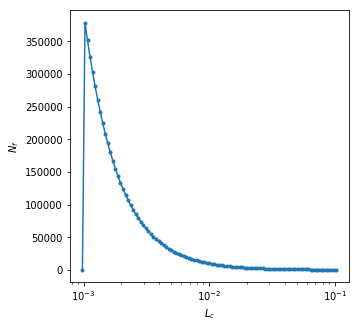

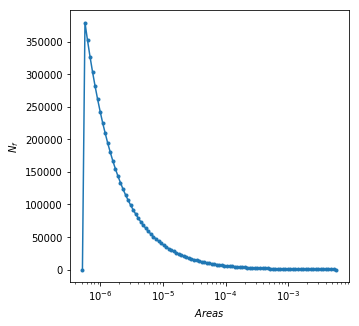

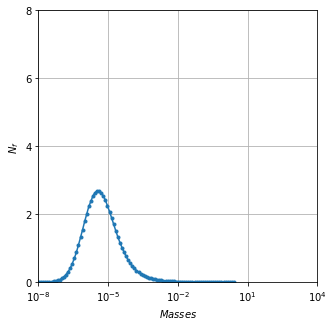

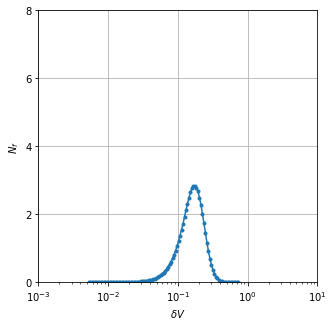

In [13]:

# bins = np.geomspace(0.001, 0.1, 100)
# N_fragments = [number_fragments(b, 1000, 10, 10, True, debris_category.rb) / 10**5 for b in bins ]
# N_fragments = (np.array(N_fragments) * 1e5).astype(int)

# L_c = np.concatenate([uniform(bins[i], bins[i+1], size=N_fragments[i]) for i in range(len(bins) - 1)])

L_c = characteristic_lengths(1000, 10, 10, True, debris_category.rb)


N_fragments_total = L_c.shape[0]
lambda_c = np.log10(L_c)
areas = avg_area(L_c)

def create_log_bins(values, nbins=100):
    #return np.geomspace(values.min(), values.max(), nbins)
    bins = np.geomspace(values.min(), values.max(), nbins)
    a = bins[1]/bins[0]
    bins = np.concatenate([[bins[0]/a], bins,[bins[-1]*a]])
    return bins

# Validating L_c
h, b = np.histogram(L_c, bins=create_log_bins(L_c))
plt.figure(figsize=(5,5))
plt.xscale('log')
plt.xlabel(r'$L_{c}$')
plt.ylabel(r'$N_f$')
plt.plot((b[:-1] + b[1:])/2, h, '.-')
plt.show()

# Validating Areas
h, b = np.histogram(areas, bins=create_log_bins(areas))
plt.figure(figsize=(5,5))
plt.xscale('log')
plt.xlabel(r'$Areas$')
plt.ylabel(r'$N_f$')
plt.plot((b[:-1] + b[1:])/2, h, '.-')
plt.show()

# Validating Mass & Velocity
AM = np.array(distribution_AM(lambda_c, debris_category.rb))
masses = areas / 10**AM

h, b = np.histogram(masses, bins=create_log_bins(masses))
plt.figure(figsize=(5,5))
plt.xscale('log')
plt.xlabel(r'$Masses$')
plt.ylabel(r'$N_f$')
plt.gca().set_yticks([0, 2, 4, 6, 8])
plt.gca().set_xticks([1e-8, 1e-5, 1e-2, 10, 1e4])
plt.gca().set_xlim([1e-8,1e4])
plt.gca().set_ylim([0,8])
plt.grid()
plt.plot((b[:-1] + b[1:])/2, h/1e5, '.-')
plt.show()

# Validating Velocity
deltaV = np.array(distribution_deltaV(AM, 10, True))


h, b = np.histogram(deltaV, bins=create_log_bins(deltaV))
plt.figure(figsize=(5,5))
plt.xscale('log')
plt.xlabel(r'$\delta V$')
plt.ylabel(r'$N_f$')
plt.gca().set_yticks([0, 2, 4, 6, 8])
plt.gca().set_xticks([1e-3, 1e-2, 1e-1, 1, 10])
plt.gca().set_xlim([1e-3,10])
plt.gca().set_ylim([0,8])
plt.grid()
plt.plot((b[:-1] + b[1:])/2, h/1e5, '.-')
plt.show()

<h3>2.3 and Onward will be alternate breakup models</h3>

<h1>3. Numerical Propagation</h1>

<h3>3.1 Modeling the Atmosphere</h3>

In [14]:
import pandas as pd

excel_file = "AtmosphericModelValues.xlsx"

tabulated_values = pd.read_excel(excel_file)
tabulated_values.head()

def atmosphere_density(altitude):
    
    # Finding the row of data for the given alitude
    ranges = [(tabulated_values["Altitude Lower Bound (km)"][i], tabulated_values["Altitude Upper Bound (km)"][i]) for i in range(len(tabulated_values))]
    row_index = 0
    for i in range(len(ranges)):
        r = ranges[i]
        if altitude >= r[0] and altitude < r[1]:
            row_index =i
            break
   # Finding relevant constants
    base_altitude = tabulated_values["Base Altitude (km)"][row_index]
    nominal_density = tabulated_values["Nominal Density (kg/m^3)"][row_index]
    scale_height = tabulated_values["Scale Height (km)"][row_index]
    
    # Model
    return nominal_density*np.e**(-(altitude-base_altitude)/(scale_height))

<h3>3.2 Calculating Orbital Elements for Debris</h3>

In [15]:
from skyfield.api import load, EarthSatellite

ts = load.timescale(builtin=True)

t = ts.now()
geocentric = iss.at(t)
init_position = geocentric.position.km

iss_mass = 419700 # kg
projectile_mass  = 227 # kg

L_c = characteristic_lengths(iss_mass, projectile_mass, 100, True, debris_category.soc)
lambda_c = np.log10(L_c)
areas = avg_area(L_c)
AM = np.array(distribution_AM(lambda_c, debris_category.soc))
masses = areas / 10**AM
deltaV = np.array(distribution_deltaV(AM, 10, True))


In [34]:
from numpy.linalg import norm

grav_param_earth = 398600.4418 #km^3s^-2
init_position = geocentric.position.km

# Generate the velocity vectors for each piece of debris
debris_velocity = velocity_vectors(len(AM), geocentric.velocity.km_per_s, deltaV)

# Eccentricity

angular_mometum = np.cross(init_position, debris_velocity)

n_hat=np.cross([0, 0, 1],angular_mometum)

eccentricity = (((norm(debris_velocity, axis=1)**2 - (grav_param_earth/norm(init_position))) * init_position[:, None]).T - ((debris_velocity.dot(init_position))[:, None]*debris_velocity)) / grav_param_earth

energy = (norm(debris_velocity, axis=1)**2 / 2) - (grav_param_earth/norm(init_position))

# If e != 0
semi_major_axis = (-grav_param_earth)/ (2*energy)
semi_latus = semi_major_axis*(1-norm(eccentricity, axis=1)**2)

inclination = np.arccos(angular_mometum[:,2]/norm(angular_mometum,axis=1)) # Radians
ascending_node = np.arccos(n_hat[:, 0]/norm(n_hat,axis=1))
argument_periapsis = np.arccos(np.multiply(n_hat, eccentricity).sum(1) / (norm(n_hat,axis=1) * norm(eccentricity, axis=1)))
true_anomaly = np.arccos((eccentricity.dot(init_position[:, None])).flatten() / (norm(eccentricity,axis=1) * norm(init_position[:, None])))

# Create debris state vectors:

debris_states = np.array([norm(eccentricity,axis=1), semi_major_axis, inclination, ascending_node, argument_periapsis, true_anomaly]).T

In [35]:
print(debris_states.shape)

(5274775, 6)
[6.00875741e-04 6.78744035e+03 9.01146314e-01 2.36780551e+00
 2.32316216e+00 1.98330945e-01]


<h1>4. Visualization </h1>

In [17]:
import rebound
sim = rebound.Simulation()

In [18]:
sim.getWidget(scale=10000, size=(500,500))

V2lkZ2V0KGNvdW50PTIsIGhlaWdodD01MDAuMCwgb3JiaXRzPVRydWUsIG9yaWVudGF0aW9uPSgwLjAsIDAuMCwgMC4wLCAxLjApLCBvdmVybGF5PXUnUkVCT1VORCAoaWFzMTUpLCBOPTAsIHTigKY=


In [19]:
sim.move_to_com()

In [20]:
earth_mass = 5.972E24 #kg
sim.add(m=earth_mass) # add earth
for i in range(len(debris_velocity)):
    sim.add(m=masses[i],a=semi_major_axis[i], e=norm(eccentricity[i]), f=true_anomaly[i],omega=argument_periapsis[i])
    if i > 100:
        break

In [21]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
sim.move_to_com()
sim.integrator = "whfast"
sim.dt = 1e-3
for i in range(10000):
    sim.integrate(sim.t+1e-9)

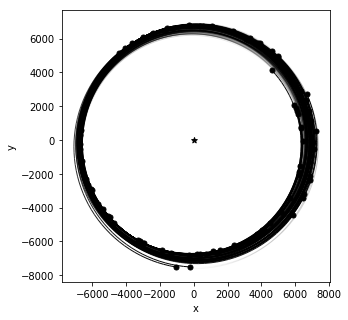

In [22]:
%matplotlib inline
fig, ax = rebound.OrbitPlot(sim)

In [23]:
sim.status()

---------------------------------
REBOUND version:     	3.12.2
REBOUND built on:    	Jul  1 2020 12:25:41
Number of particles: 	103
Selected integrator: 	whfast
Simulation time:     	1.0000000000001710e-05
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=5.972e+24 x=-2.05005638914e-26 y=1.68325797456e-26 z=0.0 vx=-5.81643283841e-20 vy=-8.9532960212e-20 vz=0.0>
<rebound.Particle object, m=7.72653884943e-07 x=558.794337425 y=6763.35113704 z=0.0 vx=-29651428996.8 vy=2374032977.11 vz=0.0>
<rebound.Particle object, m=3.67804284808e-07 x=4042.66596375 y=-5329.78521915 z=0.0 vx=23321813659.2 vy=18473769403.7 vz=0.0>
<rebound.Particle object, m=6.82533446487e-07 x=-5647.86694865 y=-3797.15985421 z=0.0 vx=16461661437.5 vy=-24274491057.3 vz=0.0>
<rebound.Particle object, m=7.69916603362e-07 x=2297.83742574 y=6462.19023679 z=0.0 vx=-28073166271.5 vy=9434008291.28 vz=0.0>
<rebound.Particle object, m=1.44697895319e-06 x=1557.729285 y=-6504.73374576 z=0.0 